In [ ]:
# !pip install split-folders
# import splitfolders
# splitfolders.ratio("D:\\Stroke Data", output="D:\\Stroke Data_Splitted\\",seed=1337, ratio=(.7, .3), group_prefix=None, move=False)

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, MultiHeadAttention, LayerNormalization, Layer
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
import cv2
from google.colab.patches import cv2_imshow
from google.colab import drive

import warnings
warnings.filterwarnings('ignore')

# Mount Google Drive
drive.mount('/content/drive')

# Define the path to your CSV files in Google Drive
# Make sure to provide the correct file paths. You can find these paths by navigating
# to the file in your Google Drive, right-clicking, and selecting "Get link."
# Replace 'YourFolder' with the appropriate folder name if your files are inside a folder.
base_path = '/content/drive/My Drive/ColabNotebooks/Cricket_Enhancement/Drive/'  # Adjust as needed


# Load your datasets
Straight_Drive_df = pd.read_csv(base_path + "Straight_Drive.csv")
Sweep_df = pd.read_csv(base_path + "Sweep.csv")
Pull_df = pd.read_csv(base_path + "Pull.csv")
onDrive_df = pd.read_csv(base_path + "onDrive.csv")
Flick_df = pd.read_csv(base_path + "Flick.csv")
Cut_df = pd.read_csv(base_path + "Cut.csv")
Cover_Drive_df = pd.read_csv(base_path + "Cover_Drive.csv")
#Cover_Drive_df = pd.read_csv(base_path + "Cover_Drive_.csv")
back_foot_punch_df = pd.read_csv(base_path + "back_foot_punch.csv")

# Now you can work with your DataFrames
print(Cover_Drive_df.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
   Unnamed: 0      F0_x      F0_y      F0_z    F0_vis      F1_x      F1_y  \
0         850  0.605604  0.319193 -0.206423  0.998100  0.608060  0.310672   
1         851  0.605210  0.320216 -0.195480  0.998275  0.607313  0.310882   
2         852  0.605156  0.321100 -0.198475  0.998430  0.607107  0.311066   
3         853  0.602378  0.320967 -0.149304  0.998564  0.604508  0.311048   
4         854  0.600436  0.320933 -0.092031  0.998703  0.602337  0.311165   

       F1_z    F1_vis      F2_x  ...   F30_vis     F31_x     F31_y     F31_z  \
0 -0.205325  0.997993  0.609513  ...  0.704735  0.636576  0.643802 -0.210230   
1 -0.193891  0.998183  0.608708  ...  0.693936  0.637445  0.648802 -0.216752   
2 -0.197096  0.998352  0.608519  ...  0.685689  0.637536  0.646330 -0.215665   
3 -0.147209  0.998500  0.605890  ...  0.679551  0.637206  0.644141 -0.173419   
4 -0.096

In [ ]:
'''
Straight_Drive_df=pd.read_csv("Straight_Drive.csv")
Sweep_df=pd.read_csv("Sweep.csv")
Pull_df=pd.read_csv("Pull.csv")
onDrive_df=pd.read_csv("onDrive.csv")
Flick_df=pd.read_csv("Flick.csv")
Cut_df=pd.read_csv("Cut.csv")
Cover_Drive_df=pd.read_csv("Cover_Drive.csv")
back_foot_punch_df=pd.read_csv("back_foot_punch.csv")
'''

In [53]:

dataframes = [back_foot_punch_df, Cover_Drive_df, Cut_df, Flick_df, onDrive_df, Pull_df, Straight_Drive_df, Sweep_df]

# Concatenating the DataFrames
dataset = pd.concat(dataframes, ignore_index=True)
dataset = dataset.drop(columns=['Unnamed: 0', 'Label'], axis=1)

In [54]:
Posdataset_numeric=dataset

# Parameters
timesteps = 10  # Number of previous frames to use for prediction
n_features = Posdataset_numeric.shape[1]  # Number of features
train_size = len(Posdataset_numeric) - 11  # Train on first frames
test_size = 11  # Test on the next frames

# Split the data into train and test sets
train_data = Posdataset_numeric.iloc[:train_size].values
test_data = Posdataset_numeric.iloc[train_size:train_size + test_size].values

# Scale the data
scaler = MinMaxScaler()
train_data_scaled = scaler.fit_transform(train_data)
test_data_scaled = scaler.transform(test_data)

# Function to create sequences
def create_sequences(data, timesteps):
    X, y = [], []
    for i in range(len(data) - timesteps):
        X.append(data[i:i + timesteps])
        y.append(data[i + timesteps])
    return np.array(X), np.array(y)

# Create sequences
X_train, y_train = create_sequences(train_data_scaled, timesteps)
X_test, y_test = create_sequences(test_data_scaled, timesteps)

In [55]:
# Reshape y_train and y_test to include the time dimension
y_train = y_train.reshape(y_train.shape[0], n_features)  # Adjusted to 2D
y_test = y_test.reshape(y_test.shape[0], n_features)  # Adjusted to 2D

# Custom layer for global average pooling
class GlobalAveragePooling(Layer):
    def call(self, inputs):
        return tf.reduce_mean(inputs, axis=1)  # Average over timesteps

# Function to build LSTM model
def build_lstm_model():
    model = Sequential()
    model.add(LSTM(64, return_sequences=False, input_shape=(timesteps, n_features)))
    model.add(Dropout(0.2))
    model.add(Dense(n_features))
    model.compile(optimizer='adam', loss='mse')
    return model

# Function to create and train Transformer model
def build_transformer_model():
    input_layer = Input(shape=(timesteps, n_features))
    attention_output = MultiHeadAttention(num_heads=4, key_dim=n_features)(input_layer, input_layer)
    attention_output = LayerNormalization(epsilon=1e-6)(attention_output)
    transformer_output = Dense(64, activation='relu')(attention_output)
    transformer_output = Dropout(0.2)(transformer_output)
    # Use the custom global average pooling layer
    pooled_output = GlobalAveragePooling()(transformer_output)
    output = Dense(n_features)(pooled_output)

    model = Model(inputs=input_layer, outputs=output)
    model.compile(optimizer='adam', loss='mse')
    return model

# Function to evaluate the model
def evaluate_model(model, X_test, y_test):
    predictions = model.predict(X_test)

    # Ensure that predictions and y_test are 2D (samples, features)
    predictions_reshaped = predictions.reshape(predictions.shape[0], n_features)
    y_test_reshaped = y_test.reshape(y_test.shape[0], n_features)

    # Inverse transform the predictions and y_test
    predictions_rescaled = scaler.inverse_transform(predictions_reshaped)
    y_test_rescaled = scaler.inverse_transform(y_test_reshaped)

    mse = mean_squared_error(y_test_rescaled, predictions_rescaled)
    mae = mean_absolute_error(y_test_rescaled, predictions_rescaled)

    return mse, mae, predictions_rescaled, y_test_rescaled


In [56]:
# Train and evaluate LSTM
lstm_model = build_lstm_model()
lstm_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=0)
lstm_mse, lstm_mae, lstm_predictions, lstm_y_test = evaluate_model(lstm_model, X_test, y_test)

# Output results for LSTM
print(f'LSTM Model MSE: {lstm_mse}, MAE: {lstm_mae}')

# Train and evaluate Transformer
transformer_model = build_transformer_model()
transformer_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=0)
transformer_mse, transformer_mae, transformer_predictions, transformer_y_test = evaluate_model(transformer_model, X_test, y_test)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
LSTM Model MSE: 0.004179525850354806, MAE: 0.042510737163824995


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


In [57]:
# Output results for Transformer
print(f'Transformer Model MSE: {transformer_mse}, MAE: {transformer_mae}')


# Predict the next frame for both models
# Correctly reshape the input for the LSTM model
next_frame_lstm = lstm_model.predict(np.reshape(X_test[-1], (1, timesteps, n_features)))
next_frame_transformer = transformer_model.predict(np.reshape(X_test[-1], (1, timesteps, n_features)))

# Inverse scale the predictions
next_frame_lstm_rescaled = scaler.inverse_transform(next_frame_lstm)
next_frame_transformer_rescaled = scaler.inverse_transform(next_frame_transformer)

# Display the predicted frame
#print("Next frame predicted by LSTM:")
#print(next_frame_lstm_rescaled)
#print("Next frame predicted by Transformer:")
#print(next_frame_transformer_rescaled)


Transformer Model MSE: 0.008729061469317206, MAE: 0.0616343928520426
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


In [2]:
def pred_actual_frame(pd, Posdataset, predictions_rescaled, y_test_rescaled):

    import cv2
    import pandas as pd
    import numpy as np

    #Posdataset
    #data = Posdataset.drop(columns=['Unnamed: 0'])
    #Features=data.drop( ['Label'], axis=1)
    #print(Features)
    # Assuming 'newdataset' is your DataFrame
    columns_list = dataset.columns.tolist()
    print(columns_list)
    preframes=predictions_rescaled

    # Reshape frames to 2D (if it is a 3D array)
    preframes = preframes.reshape(1, 132)

    # Now create the DataFrame
    PredictedFrame = pd.DataFrame(preframes, columns=columns_list)

    orgframes = y_test_rescaled
    orgframes = orgframes.reshape(1, 132)
    OrignalFrame = pd.DataFrame(orgframes, columns=columns_list)

    # Select only the columns that contain x, y, and z coordinates
    xyz_columns = [col for col in PredictedFrame.columns if '_x' in col or '_y' in col or '_z' in col]
    predicted_xyz = PredictedFrame[xyz_columns]
    original_xyz = OrignalFrame[xyz_columns]

    # Define connections between keypoints to draw the skeleton based on F1 to F32
    connections = [
        (0, 1), (1, 2), (2, 3),  # Left eye connections
        (0, 4), (4, 5), (5, 6),  # Right eye connections
        (0, 7), (0, 8),  # Nose to ears
        (9, 10),  # Mouth connection
        (11, 12),  # Shoulders
        (11, 13), (13, 15),  # Left arm (shoulder, elbow, wrist)
        (15, 17), (15, 19), (15, 21),  # Left hand (wrist to pinky, index, thumb)
        (12, 14), (14, 16),  # Right arm (shoulder, elbow, wrist)
        (16, 18), (16, 20), (16, 22),  # Right hand (wrist to pinky, index, thumb)
        (23, 24),  # Hips
        (11, 23), (12, 24),  # Shoulders to hips
        (23, 25), (25, 27), (27, 29), (27, 31),  # Left leg (hip, knee, ankle, heel, foot index)
        (24, 26), (26, 28), (28, 30), (28, 32),  # Right leg (hip, knee, ankle, heel, foot index)
    ]

    # Create a blank image (adjust size according to your coordinates)
    width, height = 640, 480  # Adjust size as needed

    # Loop through each row (frame) in the DataFrame to draw the skeleton for each frame
    for index in range(len(predicted_xyz)):
        # Clear the image for each frame
        blank_image = np.zeros((height, width, 3), dtype=np.uint8)

        # Extract (x, y) coordinates from the predicted row
        predicted_row = predicted_xyz.iloc[index]
        predicted_keypoints = []
        for i in range(0, len(predicted_row), 3):  # Skip every 3rd value because of the x, y, z format
            x = predicted_row[i] * width  # Assuming x is normalized, scale to image width
            y = predicted_row[i + 1] * height  # Assuming y is normalized, scale to image height
            predicted_keypoints.append((int(x), int(y)))

        # Extract (x, y) coordinates from the original row
        original_row = original_xyz.iloc[index]
        original_keypoints = []
        for i in range(0, len(original_row), 3):  # Skip every 3rd value because of the x, y, z format
            x = original_row[i] * width  # Assuming x is normalized, scale to image width
            y = original_row[i + 1] * height  # Assuming y is normalized, scale to image height
            original_keypoints.append((int(x), int(y)))

        # Draw circles at each keypoint for the predicted frame (color: green)
        for (x, y) in predicted_keypoints:
            cv2.circle(blank_image, (x, y), 5, (0, 255, 0), cv2.FILLED)

        # Draw lines to form the skeleton for the predicted frame (color: blue)
        for connection in connections:
            point1 = connection[0]
            point2 = connection[1]
            if point1 < len(predicted_keypoints) and point2 < len(predicted_keypoints):
                cv2.line(blank_image, predicted_keypoints[point1], predicted_keypoints[point2], (0, 255, 0), 2)

        # Draw circles at each keypoint for the original frame (color: red)
        for (x, y) in original_keypoints:
            cv2.circle(blank_image, (x, y), 5, (0, 0, 255), cv2.FILLED)

        # Draw lines to form the skeleton for the original frame (color: yellow)
        for connection in connections:
            point1 = connection[0]
            point2 = connection[1]
            if point1 < len(original_keypoints) and point2 < len(original_keypoints):
                cv2.line(blank_image, original_keypoints[point1], original_keypoints[point2], (0, 0, 255), 2)

        # Add text to indicate which color represents original and predicted
        cv2.putText(blank_image, 'Original: Pose Red', (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
        cv2.putText(blank_image, 'Predicted: Pose Green', (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
        #cv2.putText(blank_image, 'Original: Shot ' + str(Org_label[0]), (10, 80), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
        #cv2.putText(blank_image, 'Predicted: Shot ' + str(pred_label[0]), (10, 120), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

        # Show the skeleton for this frame
        #cv2.imshow('Skeleton Comparison', blank_image)
        cv2_imshow( blank_image)
        key = cv2.waitKey(50000) & 0xFF  # Adjust wait time to 30 milliseconds
        if key == ord('q'):
            print("Exiting on 'q' key press")
            break

    # Release resources
    cv2.destroyAllWindows()


    # Select only the columns that contain x, y, and z coordinates
    xyz_columns = [col for col in PredictedFrame.columns if '_x' in col or '_y' in col or '_z' in col]
    predicted_xyz = PredictedFrame[xyz_columns]
    original_xyz = OrignalFrame[xyz_columns]

    # Define connections between keypoints to draw the skeleton based on F1 to F32
    connections = [
        (0, 1), (1, 2), (2, 3),  # Left eye connections
        (0, 4), (4, 5), (5, 6),  # Right eye connections
        (0, 7), (0, 8),  # Nose to ears
        (9, 10),  # Mouth connection
        (11, 12),  # Shoulders
        (11, 13), (13, 15),  # Left arm (shoulder, elbow, wrist)
        (15, 17), (15, 19), (15, 21),  # Left hand (wrist to pinky, index, thumb)
        (12, 14), (14, 16),  # Right arm (shoulder, elbow, wrist)
        (16, 18), (16, 20), (16, 22),  # Right hand (wrist to pinky, index, thumb)
        (23, 24),  # Hips
        (11, 23), (12, 24),  # Shoulders to hips
        (23, 25), (25, 27), (27, 29), (27, 31),  # Left leg (hip, knee, ankle, heel, foot index)
        (24, 26), (26, 28), (28, 30), (28, 32),  # Right leg (hip, knee, ankle, heel, foot index)
    ]

    # Create a blank image (adjust size according to your coordinates)
    width, height = 640, 480  # Adjust size as needed

    # Loop through each row (frame) in the DataFrame to draw the skeleton for each frame
    for index in range(len(predicted_xyz)):
        # Clear images for each frame
        blank_image_predicted = np.zeros((height, width, 3), dtype=np.uint8)
        blank_image_original = np.zeros((height, width, 3), dtype=np.uint8)

        # Extract (x, y) coordinates from the predicted row
        predicted_row = predicted_xyz.iloc[index]
        predicted_keypoints = []
        for i in range(0, len(predicted_row), 3):  # Skip every 3rd value because of the x, y, z format
            x = predicted_row[i] * width  # Assuming x is normalized, scale to image width
            y = predicted_row[i + 1] * height  # Assuming y is normalized, scale to image height
            predicted_keypoints.append((int(x), int(y)))

        # Extract (x, y) coordinates from the original row
        original_row = original_xyz.iloc[index]
        original_keypoints = []
        for i in range(0, len(original_row), 3):  # Skip every 3rd value because of the x, y, z format
            x = original_row[i] * width  # Assuming x is normalized, scale to image width
            y = original_row[i + 1] * height  # Assuming y is normalized, scale to image height
            original_keypoints.append((int(x), int(y)))

        # Draw circles and lines for the predicted frame (color: green)
        for (x, y) in predicted_keypoints:
            cv2.circle(blank_image_predicted, (x, y), 5, (0, 255, 0), cv2.FILLED)
        for connection in connections:
            point1, point2 = connection
            if point1 < len(predicted_keypoints) and point2 < len(predicted_keypoints):
                cv2.line(blank_image_predicted, predicted_keypoints[point1], predicted_keypoints[point2], (0, 255, 0), 2)

        # Draw circles and lines for the original frame (color: red)
        for (x, y) in original_keypoints:
            cv2.circle(blank_image_original, (x, y), 5, (0, 0, 255), cv2.FILLED)
        for connection in connections:
            point1, point2 = connection
            if point1 < len(original_keypoints) and point2 < len(original_keypoints):
                cv2.line(blank_image_original, original_keypoints[point1], original_keypoints[point2], (0, 0, 255), 2)

        # Add text for frame labels
        cv2.putText(blank_image_original, 'Original', (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
        cv2.putText(blank_image_predicted, 'Predicted', (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

        # Concatenate the two images side by side
        comparison_image = np.hstack((blank_image_original, blank_image_predicted))

        # Display the side-by-side comparison
        #cv2.imshow('Original vs Predicted Posture', comparison_image)
        cv2_imshow( comparison_image)
        # Wait for keypress or a delay between frames
        key = cv2.waitKey(50000) & 0xFF  # Adjust the delay as needed
        if key == ord('q'):
            print("Exiting on 'q' key press")
            break

    # Release resources
    cv2.destroyAllWindows()



In [18]:
#!pip install mediapipe

In [3]:
import numpy as np
import pandas as pd
import time
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

import cv2
import tensorflow as tf
from tqdm import tqdm
import mediapipe as mp


from glob import glob
from collections import Counter
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler, LabelEncoder
from google.colab import drive
import warnings
warnings.filterwarnings('ignore')

mpPose = mp.solutions.pose
pose = mpPose.Pose()
mpDraw = mp.solutions.drawing_utils # For drawing keypoints
points = mpPose.PoseLandmark # Landmarks
data = []
a=0

# Mount Google Drive
drive.mount('/content/drive')

# Define the path to your CSV files in Google Drive
# Make sure to provide the correct file paths. You can find these paths by navigating
# to the file in your Google Drive, right-clicking, and selecting "Get link."
# Replace 'YourFolder' with the appropriate folder name if your files are inside a folder.
base_path = '/content/drive/My Drive/ColabNotebooks/Cricket_Enhancement/Drive/'   # Adjust as needed
start_time = time.time()
# Initialize video capture
cap = cv2.VideoCapture(base_path + "Sweep\\VID20221104173008 (online-video-cutter.com) (4).mp4")
# Video writer setup
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Initialize parameters
sequence_length = 11  # Using 10 frames for prediction
frame_buffer = []  # To store the sequence of frames
predictions = []  # To store predictions for each sequence of frames
predicted_frames = []  # To store predicted frames
predicted_labels = []  # To store predicted labels for each frame
original_frames = []  # To store original frames 11, 12, and 13
pTime = 0
last_frame = False  # Flag to stop future predictions after the last frame

# List of points (landmarks) to extract from each frame
points = list(range(33))  # Assuming 33 pose landmarks

Org_label = []
pred_label = []
predicted_frame = []
original_labels=[]
while True:
    success, img = cap.read()
    if not success:
        last_frame = True  # Set the flag to indicate this is the last frame
        break  # Exit the loop if no more frames

    # Convert frame to RGB
    imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Process the frame for pose detection (assuming 'pose' is initialized from MediaPipe)
    results = pose.process(imgRGB)

    if results.pose_landmarks:
        blackie = np.zeros(img.shape)  # Blank image for drawing landmarks

        # Draw landmarks on the blank image
        mpDraw.draw_landmarks(blackie, results.pose_landmarks, mpPose.POSE_CONNECTIONS)

        # Extract landmarks
        landmarks = results.pose_landmarks.landmark
        temp = []  # Temporary list for storing landmarks of the current frame

        # Extract features (x, y, z, visibility) for the current frame
        for i, j in zip(points, landmarks):
            temp.extend([j.x, j.y, j.z, j.visibility])

        # Append the current frame's features to the frame buffer
        frame_buffer.append(temp)

        # If we have 11 frames in the buffer
        if len(frame_buffer) == sequence_length:
            # Save frames 11, 12, and 13 from the original video
            original_frames = frame_buffer[-3:]

            # Create a DataFrame for the last 10 frames in the buffer
            sequence_data = pd.DataFrame(frame_buffer[-sequence_length:])

            # Append the whole sequence to features_to_pred list
            features_to_pred = [sequence_data.values]

            features_to_pred = np.array(features_to_pred)


            break

# Release resources
cap.release()
cv2.destroyAllWindows()

ModuleNotFoundError: No module named 'mediapipe'

In [40]:
len(features_to_pred[0])

NameError: name 'features_to_pred' is not defined

In [41]:
test_data_scaled = scaler.transform(features_to_pred[0])

X_test, y_test = create_sequences(test_data_scaled, timesteps)
y_test = y_test.reshape(y_test.shape[0], n_features)  # Adjusted to 2D
next_frame_lstm = lstm_model.predict(np.reshape(X_test, (1, timesteps, n_features)))
next_frame_transformer = transformer_model.predict(np.reshape(X_test, (1, timesteps, n_features)))

# Inverse scale the predictions
next_frame_lstm_rescaled = scaler.inverse_transform(next_frame_lstm)
next_frame_transformer_rescaled = scaler.inverse_transform(next_frame_transformer)

NameError: name 'features_to_pred' is not defined

In [43]:
len(features_to_pred[0])

NameError: name 'features_to_pred' is not defined

Predicted frames:
[[ 0.52887565  0.5655877  -0.21458179  0.9976413   0.52570266  0.5525178
  -0.20989542  0.99816144  0.5308856   0.5540782  -0.21314952  0.9978979
   0.5283113   0.5536625  -0.21247414  0.9978515   0.5271527   0.5594959
  -0.22200896  0.99787533  0.5299993   0.5593659  -0.22080635  0.997322
   0.5142191   0.5515587  -0.2190965   0.99777955  0.5257484   0.5502866
  -0.1680474   0.99670535  0.51653713  0.55709064 -0.21113768  0.9950688
   0.53165066  0.57047105 -0.19343652  0.9969203   0.5239256   0.5718239
  -0.20423143  0.9963941   0.5149173   0.5575057  -0.10445666  0.9990083
   0.50523365  0.5999795  -0.19662793  0.997449    0.5208134   0.5842732
  -0.09062336  0.52449     0.5087725   0.63493454 -0.20613733  0.8571686
   0.5324595   0.58631194 -0.1512017   0.50907254  0.52541447  0.60764056
  -0.17982148  0.75580084  0.5326543   0.58264387 -0.15459646  0.49946338
   0.5330332   0.59766227 -0.19049887  0.72075313  0.53240645  0.5822105
  -0.16927804  0.49413434  0.525

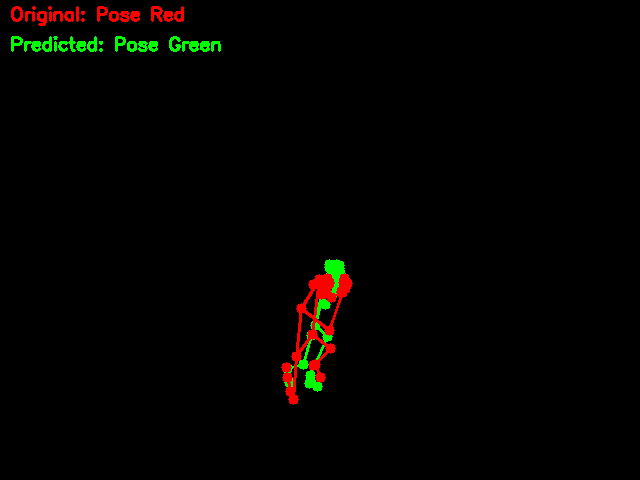

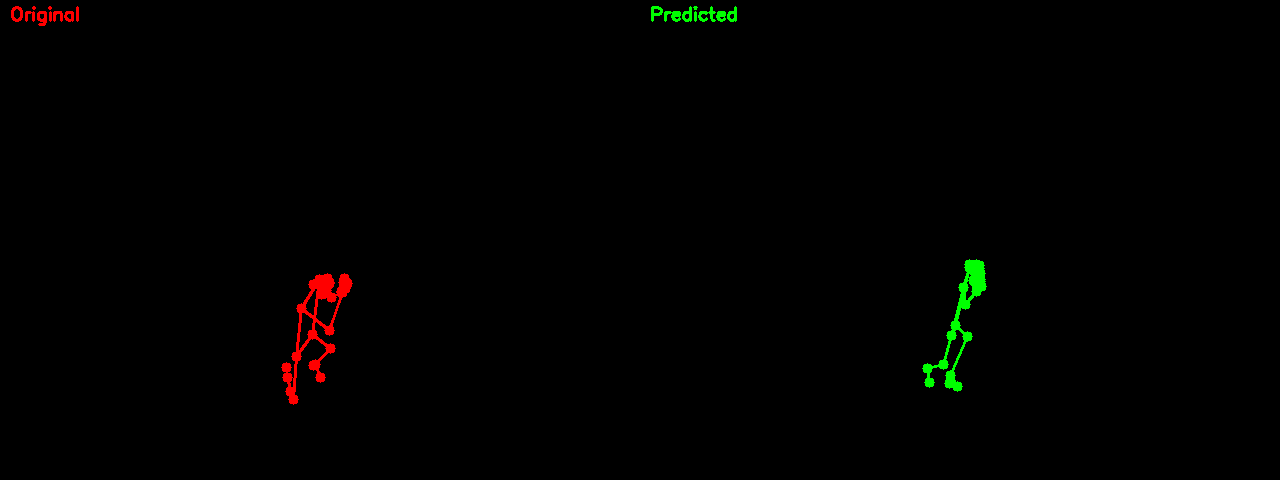

In [60]:
predictions_rescaled=next_frame_lstm_rescaled
y_test_rescaled = scaler.inverse_transform(y_test)
# Print predicted vs actual frames for comparison
print("Predicted frames:")
print(predictions_rescaled)
print("Actual frames:")
print(y_test_rescaled)

pred_actual_frame(pd,test_data_scaled, predictions_rescaled, y_test_rescaled)

In [61]:
OrignalFrame=y_test_rescaled

In [62]:
PredictedFrame=predictions_rescaled

In [63]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go

columns_list = dataset.columns.tolist()

preframes = predictions_rescaled

# Reshape frames to 2D (if it is a 3D array)
preframes = preframes.reshape(1, 132)

# Now create the DataFrame
PredictedFrame = pd.DataFrame(preframes, columns=columns_list)

orgframes = y_test_rescaled
orgframes = orgframes.reshape(1, 132)
OrignalFrame = pd.DataFrame(orgframes, columns=columns_list)

# Load DataFrame with 33 joints (columns: 'x', 'y', 'z', 'visibility')
df1 = PredictedFrame  # Replace with your actual data
df2 = OrignalFrame  # Replace with your actual data

def extract_coordinates(df):
    joints = 33  # Number of joints
    x, y, z = [], [], []

    for i in range(joints):
        x.append(df1[f'F{i}_x'].values[0])  # Take the first row's x value
        y.append(df1[f'F{i}_y'].values[0])  # Take the first row's y value
        z.append(df1[f'F{i}_z'].values[0])  # Take the first row's z value

    return np.array(x), np.array(y), np.array(z)

# Extract coordinates for both poses
x1, y1, z1 = extract_coordinates(df1)
x2, y2, z2 = extract_coordinates(df2)

# Define connections between joints based on MediaPipe PoseNet model
POSE_CONNECTIONS = [
    (0, 1), (1, 2), (2, 3), (3, 7),  # Right arm
    (0, 4), (4, 5), (5, 6), (6, 8),  # Left arm
    (9, 10), (11, 12),               # Shoulders
    (11, 13), (13, 15), (15, 17),    # Left leg
    (12, 14), (14, 16), (16, 18),    # Right leg
    (11, 23), (12, 24),              # Hips to shoulders
    (23, 24), (23, 25), (24, 26),    # Hips and upper legs
    (25, 27), (27, 29), (29, 31),    # Left lower leg
    (26, 28), (28, 30), (30, 32)     # Right lower leg
]

# Function to plot the skeleton for a single pose in 3D
def plot_skeleton(x, y, z, connections, color='blue'):
    lines = []
    for joint1, joint2 in connections:
        lines.append(go.Scatter3d(
            x=[x[joint1], x[joint2]],
            y=[y[joint1], y[joint2]],
            z=[z[joint1], z[joint2]],
            mode='lines',
            line=dict(color=color, width=5)
        ))
    return lines

# Create the 3D plot with both poses
fig = go.Figure()

# Add skeleton for both poses (in red and blue)
fig.add_traces(plot_skeleton(x1, y1, z1, POSE_CONNECTIONS, color='red'))
fig.add_traces(plot_skeleton(x2, y2, z2, POSE_CONNECTIONS, color='blue'))

# Set the layout for the 3D plot with increased size
fig.update_layout(
    title='3D Pose Skeleton Visualization',
    scene=dict(
        xaxis=dict(title='X-axis'),
        yaxis=dict(title='Y-axis'),
        zaxis=dict(title='Z-axis', range=[-1, 1]),  # Adjust range as needed
        aspectmode='cube'
    ),
    width=1200,  # Increased width
    height=800,  # Increased height
    showlegend=False
)

# Display the plot
fig.show()


In [64]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go

# Sample data loading
columns_list = dataset.columns.tolist()

preframes = predictions_rescaled.reshape(1, 132)  # Reshape predictions
PredictedFrame = pd.DataFrame(preframes, columns=columns_list)

orgframes = y_test_rescaled.reshape(1, 132)  # Reshape original data
OrignalFrame = pd.DataFrame(orgframes, columns=columns_list)
df=OrignalFrame

# Extract joint coordinates from the DataFrame
def extract_coordinates(df):
    joints = 33  # Number of joints
    x, y, z = [], [], []

    for i in range(joints):
        x.append(df[f'F{i}_x'].values[0])
        y.append(df[f'F{i}_y'].values[0])
        z.append(df[f'F{i}_z'].values[0])

    return np.array(x), np.array(y), np.array(z)

# Extract coordinates for both predicted and original poses
x1, y1, z1 = extract_coordinates(PredictedFrame)
x2, y2, z2 = extract_coordinates(OrignalFrame)

# Define MediaPipe PoseNet connections for skeleton
POSE_CONNECTIONS = [
    (0, 1), (1, 2), (2, 3), (3, 7),  # Right arm
    (0, 4), (4, 5), (5, 6), (6, 8),  # Left arm
    (9, 10), (11, 12),               # Shoulders
    (11, 13), (13, 15), (15, 17),    # Left leg
    (12, 14), (14, 16), (16, 18),    # Right leg
    (11, 23), (12, 24),              # Hips to shoulders
    (23, 24), (23, 25), (24, 26),    # Hips and upper legs
    (25, 27), (27, 29), (29, 31),    # Left lower leg
    (26, 28), (28, 30), (30, 32)     # Right lower leg
]

# Plot 3D skeleton with joints as spheres for human-like appearance
def plot_human_shape(x, y, z, connections, color='blue', joint_color='black'):
    lines = []

    # Plot lines for limbs
    for joint1, joint2 in connections:
        lines.append(go.Scatter3d(
            x=[x[joint1], x[joint2]],
            y=[y[joint1], y[joint2]],
            z=[z[joint1], z[joint2]],
            mode='lines',
            line=dict(color=color, width=8)  # Thicker lines for limbs
        ))

    # Plot spheres for joints
    lines.append(go.Scatter3d(
        x=x, y=y, z=z,
        mode='markers',
        marker=dict(size=6, color=joint_color, symbol='circle'),  # Spheres for joints
        name='Joints'
    ))

    return lines

# Find the center of the points (for centering the plot)
def calculate_center(x, y, z):
    center_x = (min(x) + max(x)) / 2
    center_y = (min(y) + max(y)) / 2
    center_z = (min(z) + max(z)) / 2
    return center_x, center_y, center_z

# Calculate center for both poses
center_x1, center_y1, center_z1 = calculate_center(x1, y1, z1)
center_x2, center_y2, center_z2 = calculate_center(x2, y2, z2)

# Offset coordinates to center them at the origin
x1, y1, z1 = x1 - center_x1, y1 - center_y1, z1 - center_z1
x2, y2, z2 = x2 - center_x2, y2 - center_y2, z2 - center_z2

# Create the 3D figure
fig = go.Figure()

# Add predicted and original pose skeletons
fig.add_traces(plot_human_shape(x1, y1, z1, POSE_CONNECTIONS, color='red', joint_color='purple'))
fig.add_traces(plot_human_shape(x2, y2, z2, POSE_CONNECTIONS, color='blue', joint_color='green'))

# Configure the layout to center the plot and set equal scaling
fig.update_layout(
    title='3D Human Pose Visualization',
    scene=dict(
        xaxis=dict(title='X-axis', range=[-1, 1], showgrid=False, zeroline=False),
        yaxis=dict(title='Y-axis', range=[-1, 1], showgrid=False, zeroline=False),
        zaxis=dict(title='Z-axis', range=[-1, 1], showgrid=False, zeroline=False),
        aspectmode='cube',  # Ensures equal scaling along all axes
    ),
    width=1200,  # Increase figure width
    height=800,  # Increase figure height
    showlegend=False
)

# Show the plot
fig.show()


In [ ]:
predictions_rescaled=next_frame_transformer_rescaled
y_test_rescaled = scaler.inverse_transform(y_test)
# Print predicted vs actual frames for comparison
print("Predicted frames:")
print(predictions_rescaled)
print("Actual frames:")
print(y_test_rescaled)
pred_actual_frame(pd, test_data_scaled, predictions_rescaled, y_test_rescaled)

In [48]:
# Print predicted vs actual frames for comparison
print("Predicted frames:")
print(predictions_rescaled)
print("Actual frames:")
print(y_test_rescaled)

Predicted frames:
[[ 0.511319    0.5647789  -0.18890642  0.99929297  0.5090436   0.5524587
  -0.18597741  0.9986591   0.51452744  0.55127573 -0.18893169  0.9980464
   0.51446503  0.5486956  -0.19185111  0.998652    0.51354194  0.5561054
  -0.19959311  0.9988114   0.5101889   0.5565688  -0.19361302  0.9977867
   0.51129884  0.5567782  -0.19846085  0.9981181   0.5110327   0.5484815
  -0.14582562  0.99619114  0.5030337   0.55374897 -0.18993488  0.9973992
   0.51596117  0.5696375  -0.17331941  0.9988503   0.5133901   0.56957686
  -0.18283392  0.99862343  0.5025061   0.5625126  -0.08833762  0.99918574
   0.48983935  0.60718524 -0.18278566  0.9981339   0.50461614  0.5847225
  -0.07223121  0.5416457   0.49432907  0.64725363 -0.1840157   0.8679022
   0.5121079   0.5916316  -0.1278753   0.5286237   0.50346446  0.6209454
  -0.1594453   0.7576195   0.507177    0.5991152  -0.14063345  0.517429
   0.50703305  0.6191413  -0.17418545  0.72979695  0.5118522   0.599036
  -0.14418104  0.5242326   0.5096

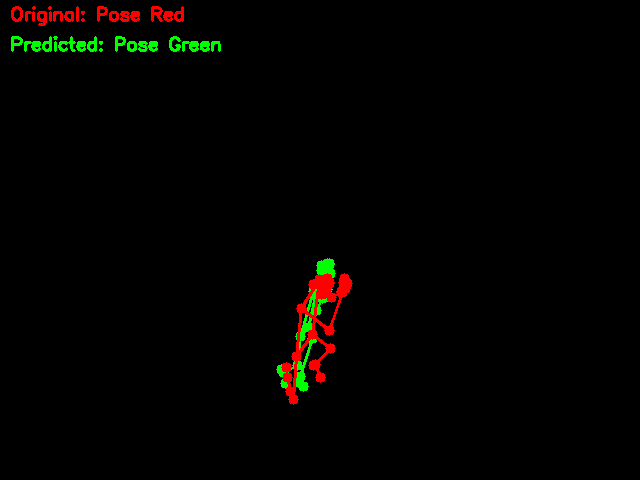

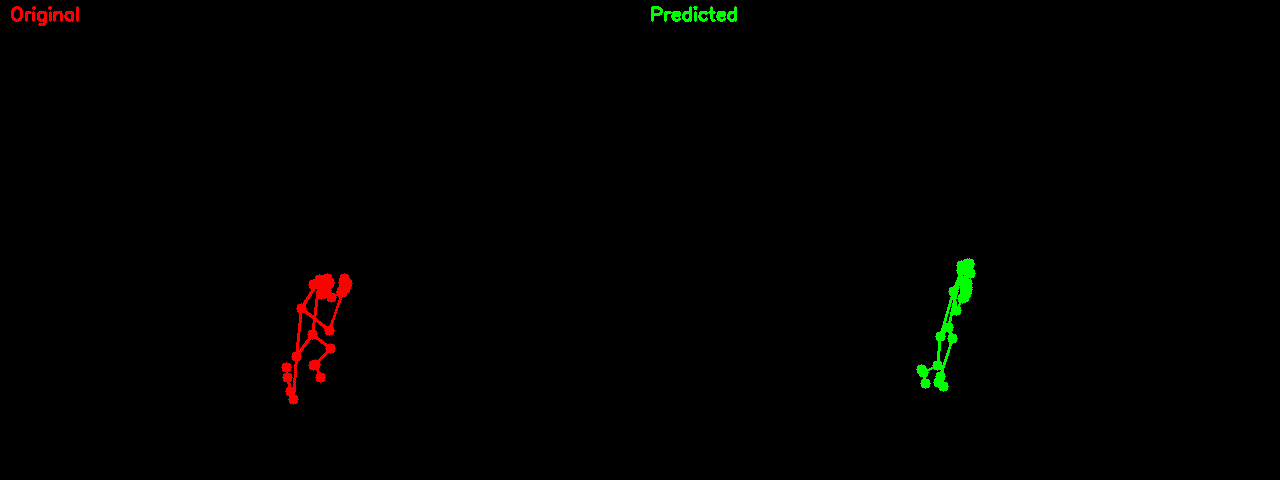

In [50]:

import cv2
import pandas as pd
import numpy as np

# Select only the columns that contain x, y, and z coordinates
xyz_columns = [col for col in PredictedFrame.columns if '_x' in col or '_y' in col or '_z' in col]
predicted_xyz = PredictedFrame[xyz_columns]
original_xyz = OrignalFrame[xyz_columns]

# Define connections between keypoints to draw the skeleton based on F1 to F32
connections = [
    (0, 1), (1, 2), (2, 3),  # Left eye connections
    (0, 4), (4, 5), (5, 6),  # Right eye connections
    (0, 7), (0, 8),  # Nose to ears
    (9, 10),  # Mouth connection
    (11, 12),  # Shoulders
    (11, 13), (13, 15),  # Left arm (shoulder, elbow, wrist)
    (15, 17), (15, 19), (15, 21),  # Left hand (wrist to pinky, index, thumb)
    (12, 14), (14, 16),  # Right arm (shoulder, elbow, wrist)
    (16, 18), (16, 20), (16, 22),  # Right hand (wrist to pinky, index, thumb)
    (23, 24),  # Hips
    (11, 23), (12, 24),  # Shoulders to hips
    (23, 25), (25, 27), (27, 29), (27, 31),  # Left leg (hip, knee, ankle, heel, foot index)
    (24, 26), (26, 28), (28, 30), (28, 32),  # Right leg (hip, knee, ankle, heel, foot index)
]

# Create a blank image (adjust size according to your coordinates)
width, height = 640, 480  # Adjust size as needed

# Loop through each row (frame) in the DataFrame to draw the skeleton for each frame
for index in range(len(predicted_xyz)):
    # Clear the image for each frame
    blank_image = np.zeros((height, width, 3), dtype=np.uint8)

    # Extract (x, y) coordinates from the predicted row
    predicted_row = predicted_xyz.iloc[index]
    predicted_keypoints = []
    for i in range(0, len(predicted_row), 3):  # Skip every 3rd value because of the x, y, z format
        x = predicted_row[i] * width  # Assuming x is normalized, scale to image width
        y = predicted_row[i + 1] * height  # Assuming y is normalized, scale to image height
        predicted_keypoints.append((int(x), int(y)))

    # Extract (x, y) coordinates from the original row
    original_row = original_xyz.iloc[index]
    original_keypoints = []
    for i in range(0, len(original_row), 3):  # Skip every 3rd value because of the x, y, z format
        x = original_row[i] * width  # Assuming x is normalized, scale to image width
        y = original_row[i + 1] * height  # Assuming y is normalized, scale to image height
        original_keypoints.append((int(x), int(y)))

    # Draw circles at each keypoint for the predicted frame (color: green)
    for (x, y) in predicted_keypoints:
        cv2.circle(blank_image, (x, y), 5, (0, 255, 0), cv2.FILLED)

    # Draw lines to form the skeleton for the predicted frame (color: blue)
    for connection in connections:
        point1 = connection[0]
        point2 = connection[1]
        if point1 < len(predicted_keypoints) and point2 < len(predicted_keypoints):
            cv2.line(blank_image, predicted_keypoints[point1], predicted_keypoints[point2], (0, 255, 0), 2)

    # Draw circles at each keypoint for the original frame (color: red)
    for (x, y) in original_keypoints:
        cv2.circle(blank_image, (x, y), 5, (0, 0, 255), cv2.FILLED)

    # Draw lines to form the skeleton for the original frame (color: yellow)
    for connection in connections:
        point1 = connection[0]
        point2 = connection[1]
        if point1 < len(original_keypoints) and point2 < len(original_keypoints):
            cv2.line(blank_image, original_keypoints[point1], original_keypoints[point2], (0, 0, 255), 2)

    # Add text to indicate which color represents original and predicted
    cv2.putText(blank_image, 'Original: Pose Red', (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
    cv2.putText(blank_image, 'Predicted: Pose Green', (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
    #cv2.putText(blank_image, 'Original: Shot ' + str(Org_label[0]), (10, 80), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
    #cv2.putText(blank_image, 'Predicted: Shot ' + str(pred_label[0]), (10, 120), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

    # Show the skeleton for this frame
    #cv2.imshow('Skeleton Comparison', blank_image)
    cv2_imshow( blank_image)
    key = cv2.waitKey(50000) & 0xFF  # Adjust wait time to 30 milliseconds
    if key == ord('q'):
        print("Exiting on 'q' key press")
        break

# Release resources
cv2.destroyAllWindows()

import cv2
import pandas as pd
import numpy as np

# Select only the columns that contain x, y, and z coordinates
xyz_columns = [col for col in PredictedFrame.columns if '_x' in col or '_y' in col or '_z' in col]
predicted_xyz = PredictedFrame[xyz_columns]
original_xyz = OrignalFrame[xyz_columns]

# Define connections between keypoints to draw the skeleton based on F1 to F32
connections = [
    (0, 1), (1, 2), (2, 3),  # Left eye connections
    (0, 4), (4, 5), (5, 6),  # Right eye connections
    (0, 7), (0, 8),  # Nose to ears
    (9, 10),  # Mouth connection
    (11, 12),  # Shoulders
    (11, 13), (13, 15),  # Left arm (shoulder, elbow, wrist)
    (15, 17), (15, 19), (15, 21),  # Left hand (wrist to pinky, index, thumb)
    (12, 14), (14, 16),  # Right arm (shoulder, elbow, wrist)
    (16, 18), (16, 20), (16, 22),  # Right hand (wrist to pinky, index, thumb)
    (23, 24),  # Hips
    (11, 23), (12, 24),  # Shoulders to hips
    (23, 25), (25, 27), (27, 29), (27, 31),  # Left leg (hip, knee, ankle, heel, foot index)
    (24, 26), (26, 28), (28, 30), (28, 32),  # Right leg (hip, knee, ankle, heel, foot index)
]

# Create a blank image (adjust size according to your coordinates)
width, height = 640, 480  # Adjust size as needed

# Loop through each row (frame) in the DataFrame to draw the skeleton for each frame
for index in range(len(predicted_xyz)):
    # Clear images for each frame
    blank_image_predicted = np.zeros((height, width, 3), dtype=np.uint8)
    blank_image_original = np.zeros((height, width, 3), dtype=np.uint8)

    # Extract (x, y) coordinates from the predicted row
    predicted_row = predicted_xyz.iloc[index]
    predicted_keypoints = []
    for i in range(0, len(predicted_row), 3):  # Skip every 3rd value because of the x, y, z format
        x = predicted_row[i] * width  # Assuming x is normalized, scale to image width
        y = predicted_row[i + 1] * height  # Assuming y is normalized, scale to image height
        predicted_keypoints.append((int(x), int(y)))

    # Extract (x, y) coordinates from the original row
    original_row = original_xyz.iloc[index]
    original_keypoints = []
    for i in range(0, len(original_row), 3):  # Skip every 3rd value because of the x, y, z format
        x = original_row[i] * width  # Assuming x is normalized, scale to image width
        y = original_row[i + 1] * height  # Assuming y is normalized, scale to image height
        original_keypoints.append((int(x), int(y)))

    # Draw circles and lines for the predicted frame (color: green)
    for (x, y) in predicted_keypoints:
        cv2.circle(blank_image_predicted, (x, y), 5, (0, 255, 0), cv2.FILLED)
    for connection in connections:
        point1, point2 = connection
        if point1 < len(predicted_keypoints) and point2 < len(predicted_keypoints):
            cv2.line(blank_image_predicted, predicted_keypoints[point1], predicted_keypoints[point2], (0, 255, 0), 2)

    # Draw circles and lines for the original frame (color: red)
    for (x, y) in original_keypoints:
        cv2.circle(blank_image_original, (x, y), 5, (0, 0, 255), cv2.FILLED)
    for connection in connections:
        point1, point2 = connection
        if point1 < len(original_keypoints) and point2 < len(original_keypoints):
            cv2.line(blank_image_original, original_keypoints[point1], original_keypoints[point2], (0, 0, 255), 2)

    # Add text for frame labels
    cv2.putText(blank_image_original, 'Original', (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
    cv2.putText(blank_image_predicted, 'Predicted', (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

    # Concatenate the two images side by side
    comparison_image = np.hstack((blank_image_original, blank_image_predicted))

    # Display the side-by-side comparison
    #cv2.imshow('Original vs Predicted Posture', comparison_image)
    cv2_imshow(comparison_image)
    # Wait for keypress or a delay between frames
    key = cv2.waitKey(50000) & 0xFF  # Adjust the delay as needed
    if key == ord('q'):
        print("Exiting on 'q' key press")
        break

# Release resources
cv2.destroyAllWindows()


In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, MultiHeadAttention, LayerNormalization, Layer
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# Load the dataset
Posdataset = pd.read_csv('Cover_Drive.csv')
Posdataset_numeric = Posdataset.drop(columns=['Unnamed: 0', 'Label'], axis=1)

# Parameters
timesteps = 10  # Number of previous frames to use for prediction
n_features = Posdataset_numeric.shape[1]  # Number of features
train_size = len(Posdataset_numeric) - 11  # Train on first frames
test_size = 11  # Test on the next frames

# Split the data into train and test sets
train_data = Posdataset_numeric.iloc[:train_size].values
test_data = Posdataset_numeric.iloc[train_size:train_size + test_size].values

# Scale the data
scaler = MinMaxScaler()
train_data_scaled = scaler.fit_transform(train_data)
test_data_scaled = scaler.transform(test_data)

# Function to create sequences
def create_sequences(data, timesteps):
    X, y = [], []
    for i in range(len(data) - timesteps):
        X.append(data[i:i + timesteps])
        y.append(data[i + timesteps])
    return np.array(X), np.array(y)

# Create sequences
X_train, y_train = create_sequences(train_data_scaled, timesteps)
X_test, y_test = create_sequences(test_data_scaled, timesteps)

# Reshape y_train and y_test to include the time dimension
y_train = y_train.reshape(y_train.shape[0], n_features)  # Adjusted to 2D
y_test = y_test.reshape(y_test.shape[0], n_features)  # Adjusted to 2D

# Custom layer for global average pooling
class GlobalAveragePooling(Layer):
    def call(self, inputs):
        return tf.reduce_mean(inputs, axis=1)  # Average over timesteps

# Function to build LSTM model
def build_lstm_model():
    model = Sequential()
    model.add(LSTM(64, return_sequences=False, input_shape=(timesteps, n_features)))
    model.add(Dropout(0.2))
    model.add(Dense(n_features))
    model.compile(optimizer='adam', loss='mse')
    return model

# Function to create and train Transformer model
def build_transformer_model():
    input_layer = Input(shape=(timesteps, n_features))
    attention_output = MultiHeadAttention(num_heads=4, key_dim=n_features)(input_layer, input_layer)
    attention_output = LayerNormalization(epsilon=1e-6)(attention_output)
    transformer_output = Dense(64, activation='relu')(attention_output)
    transformer_output = Dropout(0.2)(transformer_output)
    # Use the custom global average pooling layer
    pooled_output = GlobalAveragePooling()(transformer_output)
    output = Dense(n_features)(pooled_output)

    model = Model(inputs=input_layer, outputs=output)
    model.compile(optimizer='adam', loss='mse')
    return model

# Function to evaluate the model
def evaluate_model(model, X_test, y_test):
    predictions = model.predict(X_test)

    # Ensure that predictions and y_test are 2D (samples, features)
    predictions_reshaped = predictions.reshape(predictions.shape[0], n_features)
    y_test_reshaped = y_test.reshape(y_test.shape[0], n_features)

    # Inverse transform the predictions and y_test
    predictions_rescaled = scaler.inverse_transform(predictions_reshaped)
    y_test_rescaled = scaler.inverse_transform(y_test_reshaped)

    mse = mean_squared_error(y_test_rescaled, predictions_rescaled)
    mae = mean_absolute_error(y_test_rescaled, predictions_rescaled)

    return mse, mae, predictions_rescaled, y_test_rescaled

# Train and evaluate LSTM
lstm_model = build_lstm_model()
lstm_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=0)
lstm_mse, lstm_mae, lstm_predictions, lstm_y_test = evaluate_model(lstm_model, X_test, y_test)

# Output results for LSTM
print(f'LSTM Model MSE: {lstm_mse}, MAE: {lstm_mae}')

# Train and evaluate Transformer
transformer_model = build_transformer_model()
transformer_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=0)
transformer_mse, transformer_mae, transformer_predictions, transformer_y_test = evaluate_model(transformer_model, X_test, y_test)

# Output results for Transformer
print(f'Transformer Model MSE: {transformer_mse}, MAE: {transformer_mae}')



FileNotFoundError: [Errno 2] No such file or directory: 'Cover_Drive.csv'

In [ ]:
# Predict the next 5 frames for both models
predicted_frames_lstm = []
predicted_frames_transformer = []

# Initialize the last known input for prediction
last_input = X_test[-1]

for _ in range(5):
    # Reshape the input for both models
    next_frame_lstm = lstm_model.predict(np.reshape(last_input, (1, timesteps, n_features)))
    next_frame_transformer = transformer_model.predict(np.reshape(last_input, (1, timesteps, n_features)))

    # Inverse scale the predictions
    next_frame_lstm_rescaled = scaler.inverse_transform(next_frame_lstm)
    next_frame_transformer_rescaled = scaler.inverse_transform(next_frame_transformer)

    predicted_frames_lstm.append(next_frame_lstm_rescaled)
    predicted_frames_transformer.append(next_frame_transformer_rescaled)

    # Update last_input for the next prediction
    last_input = np.append(last_input[1:], next_frame_lstm, axis=0)




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


In [ ]:
predicted_frames_lstm

[array([[ 0.39665058,  0.4301525 , -0.12879096,  0.99972993,  0.392309  ,
          0.41931805, -0.12208446,  0.99956435,  0.3988745 ,  0.4158408 ,
         -0.13073474,  0.99933565,  0.3997283 ,  0.418661  , -0.13383533,
          0.99948335,  0.396635  ,  0.42866668, -0.11309059,  0.9993638 ,
          0.39043736,  0.4240384 , -0.11726225,  0.9991678 ,  0.38894457,
          0.42388296, -0.12253381,  0.9996328 ,  0.39215127,  0.4149689 ,
         -0.09367282,  0.99896085,  0.388604  ,  0.43305066, -0.06018421,
          0.99904376,  0.39939028,  0.43298927, -0.11287224,  0.9991746 ,
          0.40240085,  0.4423    , -0.09902638,  0.99894893,  0.4349835 ,
          0.4323356 , -0.09103313,  0.99874604,  0.4039654 ,  0.47400406,
          0.0022147 ,  0.9961736 ,  0.42068622,  0.3798944 , -0.15728155,
          0.9647141 ,  0.39171454,  0.48466903, -0.04943574,  0.8653656 ,
          0.39734668,  0.38682675, -0.16287212,  0.82573265,  0.3739533 ,
          0.43146044, -0.11355498,  0.

In [ ]:
# Convert the predicted frames to a NumPy array for easier indexing
predicted_frames_lstm = np.array(predicted_frames_lstm).squeeze()
predicted_frames_transformer = np.array(predicted_frames_transformer).squeeze()

# Prepare for visualization
# Assume you have the original frames as well, which should be the next frames in your test dataset
original_frames = y_test[-5:]  # Get the last 5 actual frames from the test set


Visualizing predictions for LSTM model...


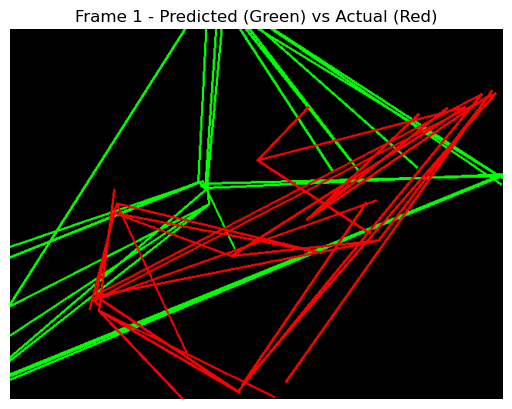

IndexError: index 1 is out of bounds for axis 0 with size 1

In [ ]:
# Create a comparison visualization
def visualize_predictions(predicted_frames, original_frames):
    # Define connections between keypoints to draw the skeleton
    connections = [
        (0, 1), (1, 2), (2, 3),  # Left eye connections
        (0, 4), (4, 5), (5, 6),  # Right eye connections
        (0, 7), (0, 8),  # Nose to ears
        (9, 10),  # Mouth connection
        (11, 12),  # Shoulders
        (11, 13), (13, 15),  # Left arm (shoulder, elbow, wrist)
        (15, 17), (15, 19), (15, 21),  # Left hand (wrist to pinky, index, thumb)
        (12, 14), (14, 16),  # Right arm (shoulder, elbow, wrist)
        (16, 18), (16, 20), (16, 22),  # Right hand (wrist to pinky, index, thumb)
        (23, 24),  # Hips
        (11, 23), (12, 24),  # Shoulders to hips
        (23, 25), (25, 27), (27, 29), (27, 31),  # Left leg (hip, knee, ankle, heel, foot index)
        (24, 26), (26, 28), (28, 30), (28, 32),  # Right leg (hip, knee, ankle, heel, foot index)
    ]

    # Create a blank image for visualization
    width, height = 640, 480  # Adjust size as needed

    # Loop through each predicted and actual frame to draw the skeleton
    for i in range(len(predicted_frames)):
        # Create a blank image for the current frame
        blank_image = np.zeros((height, width, 3), dtype=np.uint8)

        # Extract (x, y) coordinates from the predicted frame
        predicted_keypoints = []
        for j in range(0, len(predicted_frames[i]), 3):  # Skip every 3rd value (x, y, z)
            x = predicted_frames[i][j] * width  # Scale to image width
            y = predicted_frames[i][j + 1] * height  # Scale to image height
            predicted_keypoints.append((int(x), int(y)))

        # Extract (x, y) coordinates from the original frame
        original_keypoints = []
        for j in range(0, len(original_frames[i]), 3):  # Skip every 3rd value (x, y, z)
            x = original_frames[i][j] * width  # Scale to image width
            y = original_frames[i][j + 1] * height  # Scale to image height
            original_keypoints.append((int(x), int(y)))

        # Draw the skeleton for the predicted frame
        for connection in connections:
            start, end = connection
            if start < len(predicted_keypoints) and end < len(predicted_keypoints):
                cv2.line(blank_image, predicted_keypoints[start], predicted_keypoints[end], (0, 255, 0), 2)

        # Draw the skeleton for the original frame
        for connection in connections:
            start, end = connection
            if start < len(original_keypoints) and end < len(original_keypoints):
                cv2.line(blank_image, original_keypoints[start], original_keypoints[end], (0, 0, 255), 2)

        # Display the image
        plt.imshow(cv2.cvtColor(blank_image, cv2.COLOR_BGR2RGB))
        plt.title(f'Frame {i + 1} - Predicted (Green) vs Actual (Red)')
        plt.axis('off')
        plt.show()

# Visualize predictions for both models
print("Visualizing predictions for LSTM model...")
visualize_predictions(predicted_frames_lstm, original_frames)
print("Visualizing predictions for Transformer model...")
visualize_predictions(predicted_frames_transformer, original_frames)


LSTM Working model

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Input
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# Load your datasets
Posdataset = pd.read_csv('Cover_Drive.csv')
Posdataset_numeric = Posdataset.drop(columns=['Unnamed: 0', 'Label'], axis=1)

# Parameters
timesteps = 10  # Number of previous frames to use for prediction
n_features = Posdataset_numeric.shape[1]  # Number of features
train_size = len(Posdataset_numeric) - 11  # Train on first frames
test_size = 11  # Test on the next frames

# Split the data into train and test sets
train_data = Posdataset_numeric.iloc[:train_size].values
test_data = Posdataset_numeric.iloc[train_size:train_size + test_size].values

# Scale the data
scaler = MinMaxScaler()
train_data_scaled = scaler.fit_transform(train_data)
test_data_scaled = scaler.transform(test_data)

# Function to create sequences
def create_sequences(data, timesteps):
    X, y = [], []
    for i in range(len(data) - timesteps):
        X.append(data[i:i + timesteps])
        y.append(data[i + timesteps])
    return np.array(X), np.array(y)

# Create sequences
X_train, y_train = create_sequences(train_data_scaled, timesteps)
X_test, y_test = create_sequences(test_data_scaled, timesteps)

# Reshape y_train and y_test to include the time dimension
y_train = y_train.reshape(y_train.shape[0], 1, y_train.shape[1])
y_test = y_test.reshape(y_test.shape[0], 1, y_test.shape[1])

# Function to build LSTM model
def build_lstm_model():
    model = Sequential()
    model.add(LSTM(64, return_sequences=False, input_shape=(timesteps, n_features)))
    model.add(Dropout(0.2))
    model.add(Dense(n_features))
    model.compile(optimizer='adam', loss='mse')
    return model

# Function to evaluate the model
def evaluate_model(model, X_test, y_test):
    predictions = model.predict(X_test)

    # Ensure that predictions and y_test are 2D (samples, features)
    predictions_reshaped = predictions.reshape(predictions.shape[0], n_features)
    y_test_reshaped = y_test.reshape(y_test.shape[0], n_features)

    # Inverse transform the predictions and y_test
    predictions_rescaled = scaler.inverse_transform(predictions_reshaped)
    y_test_rescaled = scaler.inverse_transform(y_test_reshaped)

    mse = mean_squared_error(y_test_rescaled, predictions_rescaled)
    mae = mean_absolute_error(y_test_rescaled, predictions_rescaled)

    return mse, mae, predictions_rescaled, y_test_rescaled

# Train and evaluate LSTM
lstm_model = build_lstm_model()
lstm_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=0)
lstm_mse, lstm_mae, lstm_predictions, lstm_y_test = evaluate_model(lstm_model, X_test, y_test)

# Output results
print(f'LSTM Model MSE: {lstm_mse}, MAE: {lstm_mae}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
LSTM Model MSE: 0.01170026497639083, MAE: 0.0704915001423973
